In [1]:

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold, SequentialFeatureSelector, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, RFE 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import skew
import numpy as np
#from scipy.cluster import hierarchy
from pathlib import Path
import matplotlib.patches as mpatches
import joblib
from joblib import dump
import shap

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.prediction.aggregates.test import load_models, generate_predictions, plot_predictions
from src.emotion.utils.constants import DATA_DIR

%matplotlib inline
plt.style.use('ggplot')

# set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_big.csv')

In [3]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [4]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(103, 9351)

In [5]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(103, 9348)


In [6]:
# Detect outliers
# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(103, 8757)
(103, 8757)


In [7]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [8]:
X

,Angry__has_duplicate_max,Angry__has_duplicate_min,Angry__has_duplicate,Angry__sum_values,Angry__abs_energy,Angry__mean_abs_change,Angry__mean_change,Angry__mean_second_derivative_central,Angry__median,Angry__mean,...,GazeDifference_Mean,GazeDifference_Min,GazeDifference_Max,GazeDifference_Range,MutualGaze_Mean,MutualGaze_Min,MutualGaze_Max,MutualGaze_Range,Std_X_Center,Std_Y_Center
0,0.0,0.0,0.0,2790.659981,361.447239,0.000568,-4.452560e-06,1.663933e-08,0.058852,0.074925,...,0.083773,0.004999,0.124410,0.119411,0.668956,0.006868,1.000000,0.993132,61.790026,7.815094
1,0.0,0.0,0.0,3303.134586,795.130125,0.000767,-6.244523e-06,5.890602e-09,0.035078,0.081019,...,0.623172,0.000745,1.000000,0.999255,0.619863,0.239726,1.000000,0.760274,15.450240,5.480104
2,0.0,0.0,0.0,2717.605536,396.566139,0.000617,-3.538581e-06,1.103928e-08,0.042817,0.066657,...,0.297222,0.001675,0.868770,0.867095,0.353278,0.000484,1.000000,0.999516,18.314267,7.647716
3,0.0,0.0,0.0,491.454595,20.395678,0.000249,-5.474331e-07,1.240134e-08,0.024320,0.028625,...,0.544020,0.102414,1.000000,0.897586,0.488372,0.226744,1.000000,0.773256,17.854632,14.042255
4,0.0,0.0,0.0,886.778743,71.940749,0.000496,1.078064e-05,5.794579e-08,0.043003,0.051701,...,0.407937,0.004921,1.000000,0.995079,0.337334,0.000300,1.000000,0.999700,31.613157,4.343766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.0,0.0,1.0,281.550546,6.893867,0.000110,-4.347492e-07,1.816060e-09,0.007954,0.011841,...,0.529081,0.314259,0.711538,0.397280,0.538605,0.396733,0.646154,0.249421,56.535975,9.585008
99,0.0,0.0,1.0,1304.422066,130.804402,0.000557,1.164116e-06,2.180866e-08,0.046162,0.056298,...,0.524234,0.258443,1.000000,0.741557,0.679487,0.038462,1.000000,0.961538,20.995753,8.214786
100,0.0,0.0,0.0,567.357355,29.132381,0.000152,1.568343e-07,-5.294283e-09,0.005712,0.013723,...,0.146036,0.000929,0.387589,0.386659,0.671447,0.014342,1.000000,0.985658,6.984513,2.842056
101,0.0,0.0,0.0,890.864502,107.076521,0.000355,1.668826e-08,-2.525917e-09,0.013866,0.035408,...,0.488327,0.019643,0.777976,0.758333,0.683027,0.049080,1.000000,0.950920,5.836697,3.282349


In [9]:
# Scale Features
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()

# Calculate skewness of each feature
skewness = skew(X, axis=0)

# Create empty list to store scaled features
scaled_features = []
# Create an empty dictionary to store scalers
scalers_dict = {}

# Scale features using appropriate scaler
for feat, s in zip(X.columns, skewness):
    if abs(s) < 0.5:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    scaled_feat = scaler.fit_transform(X[feat].values.reshape(-1, 1)).flatten()
    scaled_features.append(pd.Series(scaled_feat, name=feat))
    # Add the trained scaler to the dictionary
    scalers_dict[feat] = scaler

# Concatenate scaled features into new DataFrame
scaled_X = pd.concat(scaled_features, axis=1)

# Fit the scaler to the dataframe and transform the dataframe
Y = pd.DataFrame(minmax_scaler.fit_transform(Y), columns=['P', 'E', 'R', 'M', 'A'])

# Add the trained target scaler to the dictionary
scalers_dict['target_scaler'] = minmax_scaler

path = "/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/" + "scalers_dict.joblib"
# Now save the dictionary with joblib
dump(scalers_dict, path)


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


['/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/scalers_dict.joblib']

In [10]:
# scaled_X.dropna()
# scaled_Y.dropna()

In [11]:
# It does not work on X_train, because the shuffeling in train-test-split introduces values which lead to missing values in the correlation matrix!
# corr_matrix = X.corr()

In [12]:
def plot_correlation_matrix(matrix):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")

In [13]:
# plot_correlation_matrix(X)

In [14]:
# # Feature selection: runs in ~ 5min 
# # Step 1: Identify feature clusters
# # Create a dendrogram using hierarchical clustering
# linkage = hierarchy.linkage(corr_matrix, method='complete')
# plt.figure(figsize=(10, 5))
# plt.title('Dendrogram')
# plt.xlabel('Data points')
# plt.ylabel('Distance')
# hierarchy.dendrogram(
#     linkage,
#     leaf_rotation=0.,  # Rotate x-axis labels
#     leaf_font_size=12.,  # Font size for x-axis labels
# )
# plt.show()

In [15]:
# # Get clusters from the dendrogram
# max_d = 15 # Maximum distance between clusters
# clusters = hierarchy.fcluster(linkage, max_d, criterion='distance')

In [16]:
# # Group columns by cluster
# df = pd.DataFrame(corr_matrix)
# df.columns = ['col_' + str(i) for i in range(df.shape[1])]
# df['cluster'] = clusters
# grouped = df.groupby('cluster')

# # Get the size of each group
# group_sizes = grouped.size()

# # Plot the group sizes
# plt.figure(figsize=(10,5))
# plt.bar(x=group_sizes.index, height=group_sizes.values, color='blue')
# plt.title('Group Sizes')
# plt.xlabel('Group')
# plt.ylabel('Size')
# plt.show()

In [17]:
# # Use feature with the highest correlation to the target
# # Step 3: Calculate the correlation matrix between the columns of X and the columns of Y
# corr_matrix = np.abs(np.corrcoef(X.T, Y.T)[:X.shape[1], X.shape[1]:])

# # compute the row-wise averages of the matrix
# avg_matrix = np.mean(corr_matrix, axis=1, keepdims=True)

# # concatenate the average matrix with the group array
# concat_matrix = np.concatenate([avg_matrix, clusters.reshape(len(clusters), 1)], axis=1)

# # sort the concatenated matrix by group
# sorted_matrix = concat_matrix[concat_matrix[:, -1].argsort()]

# # find the maximum value in each group and its index
# max_values = []
# # iterate over the unique groups in the second column of the sorted matrix
# for group in np.unique(sorted_matrix[:, 1]):
#     # find the indices of rows that belong to the current group
#     indices = np.where(sorted_matrix[:, 1] == group)[0]
#     # get the maximum value in the first column for the current group
#     max_value = np.max(sorted_matrix[indices, 0])
#     # append the maximum value to the list
#     max_values.append(max_value)
    
    
# # find the indices of all the maximum values in the avg_matrix
# max_indices = []
# for max_value in max_values:
#     indices = np.where(avg_matrix == max_value)[0]
#     max_indices.extend(indices)

# X_filtered = X.iloc[:, max_indices]
# print(X_filtered.shape)


In [18]:
# # Use closest feature to group mean!
# # Create a dictionary to map column names to their indices in the original matrix X
# column_name_to_index = {name: i for i, name in enumerate(X.columns)}

# closest_feature_indices = []

# for name, group in grouped:
#     cluster_mean = group.iloc[:, :-1].mean(axis=0).values
    
#     min_distance = float('inf')
#     min_distance_feature_index = None
    
#     for index, row in group.iterrows():
#         feature_vector = row.iloc[:-1].values
#         distance = np.linalg.norm(feature_vector - cluster_mean)
        
#         if distance < min_distance:
#             min_distance = distance
#             min_distance_feature_index = column_name_to_index[row.name]  # Get the column index from the row name
    
#     closest_feature_indices.append(min_distance_feature_index)

# X_filtered = X.iloc[:, closest_feature_indices]
# print(X_filtered.shape)

In [19]:
# plot_correlation_matrix(X_filtered)

In [20]:
# def get_selected_voting_features_multi(Y, X_filtered, filter_methods, k):
#     feature_counts = np.zeros(X_filtered.shape[1])
    
#     #print(Y.shape[1])
#     print(len(Y.T))
    
#     for i in range(len(Y.T)):
#         y_i = Y.iloc[:, i]
        
#         for method_name, method in filter_methods.items():
#             pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
#             pipeline.fit(X_filtered, y_i)
#             selected_i = pipeline.named_steps[method_name].get_support(indices=True)
            
#             # Increment the count for each selected feature
#             for index in selected_i:
#                 feature_counts[index] += 1
                
#     # Get the indices of the top k features with the most counts
#     top_k_features = np.argsort(feature_counts)[-k:]
    
#     return top_k_features

In [21]:
# filter_methods = {
#     'f_regression': SelectKBest(f_regression, k=10),
#     'mutual_info_regression': SelectKBest(mutual_info_regression, k=10),
#     'variance_threshold': VarianceThreshold(threshold=0.1),
# }

# all_selected_features = get_selected_voting_features_multi(Y, X_filtered, filter_methods, k=15)

# print("Fused selected features:", all_selected_features)


In [22]:
# X_final = X_filtered.iloc[:, list(set(all_selected_features))]
# plot_correlation_matrix(X_final)
# column_names = X_final.columns.tolist()
# print(column_names)

In [23]:
# models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor", "SVR"]

# for name in models_to_drop:
#     for i in range(len(MODELS)):
#         if MODELS[i]["name"] == name:
#             del MODELS[i]
#             break
        
# for model in MODELS:
#     print(model["name"])

In [24]:
# # Runs in ~5 min for n_fols=5
# search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], n_folds=5, n_jobs=-1)

# results = search.run(X_final, Y, save=False)

In [25]:
# best_feats_dict = {model[0]['name']: model[0]['best_feats'] for model in results}
# #print(best_feats_dict)

In [26]:
# for model in best_feats_dict.keys():
#     print(f"Algorithm: {model}")
#     # Get the feature importance values for the algorithm
#     feat_imp_vals = best_feats_dict[model]
#     # Map the feature importance values with the feature list using a dictionary comprehension
#     feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
#     # Rank the features by their importance value in descending order
#     ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
#     # Print the ranked features
#     #print(ranked_feats)

In [27]:
# eval_metric = "mean_absolute_error"

# # Plot the results
# mae_scores = [
#     rd["score"]
#     for result_list in results
#     for rd in result_list
#     if rd["metric"] == eval_metric
# ]
# model_names = [
#     rd["name"]
#     for result_list in results
#     for rd in result_list
#     if rd["metric"] == eval_metric
# ]
# plt.bar(model_names, mae_scores)
# plt.title("Mean Absolute Error Scores")
# plt.xlabel("Model")
# plt.ylabel("Score")
# plt.xticks(rotation=45) 
# plt.show()

In [28]:
# Print the model with the lowest score
# best_model = min(
#     [
#         min(
#             sublist,
#             key=lambda x: x["score"]
#             if x["metric"] == eval_metric
#             else float("inf"),
#         )
#         for sublist in results
#     ],
#     key=lambda x: x["score"],
# )
# print(f"Best model: {best_model['name']}")
# print(f"Best params: {best_model['params']}")
# print(f"Best Score: {best_model['score']}")

In [29]:
def get_selected_voting_features_combined(Y, X, filter_methods, wrapper_methods, k):
    #np.random.seed(1)
    
    feature_counts = np.zeros(X.shape[1])

    # Apply filter methods
    for _, method in filter_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        print(len(selected_i))
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1

    # Apply wrapper methods
    for _, method in wrapper_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
    
    # Get the indices of the top k features with the most counts
    #selected_features = np.argsort(feature_counts)[-k:]
    selected_features = np.where(feature_counts >= k)[0]
    print(np.sort(feature_counts))
    
    return selected_features

In [30]:
X_filtered = scaled_X

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, Y, test_size=0.2, random_state=42)

In [32]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=8),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=8),
    #'variance_threshold': VarianceThreshold(threshold=1000.0),
    'select_percentile': SelectPercentile(f_regression, percentile=0.5),
    'select_fpr': SelectFpr(f_regression, alpha=0.005),
    #'select_fdr': SelectFdr(f_regression, alpha=0.955),
    'select_fwe': SelectFwe(f_regression, alpha=1.0),
    #'rfe_regression': RFEC(LinearRegression(), n_features_to_select=8),
}

wrapper_methods = {
    #'sfs_regression': SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='forward', n_jobs=-1),
    #'sbs_regression': SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='backward', n_jobs=-1),
}


# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_combined(Y_train.iloc[:, i], X_train, filter_methods, wrapper_methods, k=3)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features
    
# Save the dictionary with joblib
path = "/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/" + "selected_features.joblib"
dump(perma_dict, path)

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])


8
8
44
21
0
[0. 0. 0. ... 3. 3. 3.]
8
8
44
19
0
[0. 0. 0. ... 3. 3. 3.]
8
8
44
183
7
[0. 0. 0. ... 4. 4. 4.]
8
8
44
34
0
[0. 0. 0. ... 3. 3. 3.]
8
8
44
30
0
[0. 0. 0. ... 3. 3. 3.]
P : [ 966  978 1423 3455 4087 4962 5671 6861]
E : [ 577 3797 3864 3998 4332 5241 6370 6700]
R : [1125 1225 1952 1958 2977 5600 7041 7059]
M : [  41 1612 1613 2033 4087 6414 6991 7181]
A : [2803 3325 3912 4208 4962 6985 6986 7076]


In [33]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    #X_test_final = X_test.iloc[:, list(set(selected_features))]
    column_names = X_train_final.columns.tolist()
    X_test_final = X_test[column_names]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)

P : ['Neutral__fft_coefficient__attr_"angle"__coeff_80', 'Disgust__fft_coefficient__attr_"real"__coeff_12', 'Valence__fft_coefficient__attr_"angle"__coeff_67', 'Dominance__fft_coefficient__attr_"real"__coeff_97', 'Disgust__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'Disgust__fft_coefficient__attr_"real"__coeff_24', 'Fear__fft_coefficient__attr_"abs"__coeff_28', 'Surprise__fft_coefficient__attr_"angle"__coeff_23']
E : ['Angry__fft_coefficient__attr_"angle"__coeff_51', 'Arousal__fft_coefficient__attr_"angle"__coeff_36', 'Fear__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'Dominance__ar_coefficient__coeff_7__k_10', 'Fear__ar_coefficient__coeff_8__k_10', 'Fear__fft_coefficient__attr_"real"__coeff_4', 'Valence__ar_coefficient__coeff_7__k_10', 'Fear__fft_coefficient__attr_"imag"__coeff_39']
R : ['Happy__fft_coefficient__attr_"abs"__coeff_72', 'Surprise__partial_autocorrelation__lag_3', 'Valence__fft_coefficient__attr_"abs"__coeff_96', 'Dominance__fft_coefficient

In [34]:
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    Lasso,
    LinearRegression,
    Ridge,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

random_state = 0

MODELS = [
    {
        "name": "MLPRegressor",
        "model": MLPRegressor(max_iter=2000),
        "params": {
            "hidden_layer_sizes": [(64, 32), (128, 64)],
            "alpha": [0.001, 0.01, 0.1],
            "learning_rate_init": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "KNeighborsRegressor",
        "model": KNeighborsRegressor(),
        "params": {"n_neighbors": [1, 5, 10, 15, 20]},
    },
    {
        "name": "DecisionTreeRegressor",
        "model": DecisionTreeRegressor(),
        "params": {"max_depth": range(2, 11)},
        "random_state": [random_state],
    },
    {
        "name": "RandomForestRegressor",
        "model": RandomForestRegressor(),
        "params": {"n_estimators": [50, 100, 200, 400], "max_depth": range(2, 6)},
        "random_state": [random_state],
    },
    {
        "name": "ExtraTreesRegressor",
        "model": ExtraTreesRegressor(),
        "params": {"n_estimators": [50, 100, 200, 400], "max_depth": range(2, 6)},
        "random_state": [random_state],
    },
    {
        "name": "GradientBoostingRegressor",
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "AdaBoostRegressor",
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "SVR",
        "model": SVR(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1.0, 10.0],
            "epsilon": [0.01, 0.1, 1.0],
        },
    },
    {
        "name": "LinearRegression",
        "model": LinearRegression(),
        "params": {},
    },
    {
        "name": "Ridge",
        "model": Ridge(),
        "params": {"alpha": [0.001, 0.01, 0.1, 1.0]},
        "random_state": [random_state],
    },
    {
        "name": "Lasso",
        "model": Lasso(),
        "params": {"alpha": [0.001, 0.01, 0.1, 1.0]},
        "random_state": [random_state],
    },
    {
        "name": "ElasticNet",
        "model": ElasticNet(),
        "params": {"alpha": [0.001, 0.01, 0.1, 1.0], "l1_ratio": [0.1, 0.5, 0.9]},
        "random_state": [random_state],
    },
    {
        "name": "BayesianRidge",
        "model": BayesianRidge(),
        "params": {
            "alpha_1": [0.001, 0.01, 0.1, 1.0],
            "alpha_2": [0.001, 0.01, 0.1, 1.0],
        },
    },
    {
        "name": "CatBoostRegressor",
        "model": CatBoostRegressor(verbose=False),
        "params": {
            "iterations": [50, 100, 200, 400],
            "depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1, 1.0],
            "random_state": [random_state],
        },
    },
    {
        "name": "XGBRegressor",
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
]


In [35]:
SAVE_DIR = Path("/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big")

eval_metric = "mean_absolute_error"

In [36]:
models_to_drop = ["MLPRegressor", "KNeighborsRegressor"]

for name in models_to_drop:
    for i in range(len(MODELS)):
        if MODELS[i]["name"] == name:
            del MODELS[i]
            break
        
for model in MODELS:
    print(model["name"])

DecisionTreeRegressor
RandomForestRegressor
ExtraTreesRegressor
GradientBoostingRegressor
AdaBoostRegressor
SVR
LinearRegression
Ridge
Lasso
ElasticNet
BayesianRidge
CatBoostRegressor
XGBRegressor


In [37]:
results_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR / perma_dim
    search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")
    results = search.run(X_final["train"], Y_train[perma_dim], save=True)
    results_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for DecisionTreeRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/DecisionTreeRegressor.joblib
Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/ExtraTreesRegressor.joblib
Models for GradientBoostingRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/GradientBoostingRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/AdaBoostRegressor.joblib
Models for SVR saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/SVR.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/P/LinearRegression.joblib
Models for Ridge saved 

In [38]:
# perma_models = {}

# for perma_dim in ["P", "E", "R", "M", "A"]:
#     models_path = SAVE_DIR / perma_dim
#     models = load_models(models_path)
#     perma_models[perma_dim] = models

In [39]:
best_models = {}

for perma_dim, results in results_dict.items():
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    # print(perma_dim)
    # print(f"Best model: {best_model['name']}")
    # print(f"Best params: {best_model['params']}")
    # print(f"Best Score: {best_model['score']}")
    best_models[perma_dim] = best_model['name']
    
# Save the best models with joblib
path = "/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/" + "best_models.joblib"
dump(best_models, path)

['/home/moritz/Workspace/masterthesis/model/custom_models/univariate/big/best_models.joblib']

In [40]:
def load_best_model(file_path: Path):

    models = {}

    if file_path.is_file():
        model = joblib.load(file_path)

        models[str(file_path.stem)] = model

    return models

In [41]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR / perma_dim / (best_models[perma_dim] + ".joblib")
    models = load_best_model(models_path)
    perma_models[perma_dim] = models

In [42]:
def print_models(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        if model_name == "CatBoostRegressor":
            print(model.get_params())
        else:
            print(model)
        
for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    print_models(models, X_test, Y_test[dim])

BayesianRidge(alpha_1=1.0, alpha_2=1.0)
BayesianRidge(alpha_1=1.0, alpha_2=1.0)
BayesianRidge(alpha_1=1.0, alpha_2=1.0)
BayesianRidge(alpha_1=1.0, alpha_2=0.001)
BayesianRidge(alpha_1=0.001, alpha_2=0.1)


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def generate_predictions(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate mean squared error and mean absolute error
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        results[model_name] = {"mae": mae, "mse": mse, "y_pred": y_pred}
    return results

In [44]:
def generate_shap_values_and_ranks(dim, models, X):
    feature_rankings = {}

    for i, (model_name, mae_grid_search) in enumerate(models.items()):
        model = mae_grid_search[0].best_estimator_
        print(model_name)

        if model_name in ["ElasticNet", "Lasso", "Ridge", "LinearRegression", "BayesianRidge"]:
            explainer = shap.LinearExplainer(model, X, feature_names=X.columns)
        elif model_name in ["AdaBoostRegressor"]:
            explainer = shap.SamplingExplainer(model.predict, X)
        else:
            explainer = shap.Explainer(model, feature_names=X.columns)

        shap_values = explainer(X)
        shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False)
        # path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results/big_regr_shap"
        # image = path + "/" + dim[i].lower() + "_big_regr.pdf"
        # plt.savefig(image, bbox_inches='tight', dpi=300)
        # plt.close()  # close the plot

        # Get the mean absolute shap values for each feature
        mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

        # Create a DataFrame for easy sorting and manipulation
        feature_shap_df = pd.DataFrame(list(zip(X.columns, mean_abs_shap_values)), 
                                       columns=['feature','mean_abs_shap'])

        # Sort by the mean absolute shap value and add rank column
        feature_shap_df = feature_shap_df.sort_values('mean_abs_shap', ascending=False)
        feature_shap_df['rank'] = range(1, len(feature_shap_df) + 1)
        
        # Store the ranking in the dictionary
        feature_rankings[model_name] = feature_shap_df[['feature', 'rank']].set_index('feature').to_dict()['rank']

    return feature_rankings

def aggregate_ranks(feature_rankings_perma):
    aggregated_ranks = {}
    for dim, feature_rankings in feature_rankings_perma.items():
        # Calculate the total rank and count for each feature
        total_ranks = {}
        counts = {}
        for model_name, ranks in feature_rankings.items():
            for feature, rank in ranks.items():
                if feature in total_ranks:
                    total_ranks[feature] += rank
                    counts[feature] += 1
                else:
                    total_ranks[feature] = rank
                    counts[feature] = 1

        # Calculate the mean rank for each feature
        mean_ranks = {feature: total_ranks[feature] / counts[feature] for feature in total_ranks}

        # Sort the features by their mean ranks
        sorted_features = sorted(mean_ranks, key=mean_ranks.get)
        aggregated_ranks[dim] = sorted_features

    return aggregated_ranks

P
BayesianRidge


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


E
BayesianRidge


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


R
BayesianRidge


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


M
BayesianRidge


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


A
BayesianRidge


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


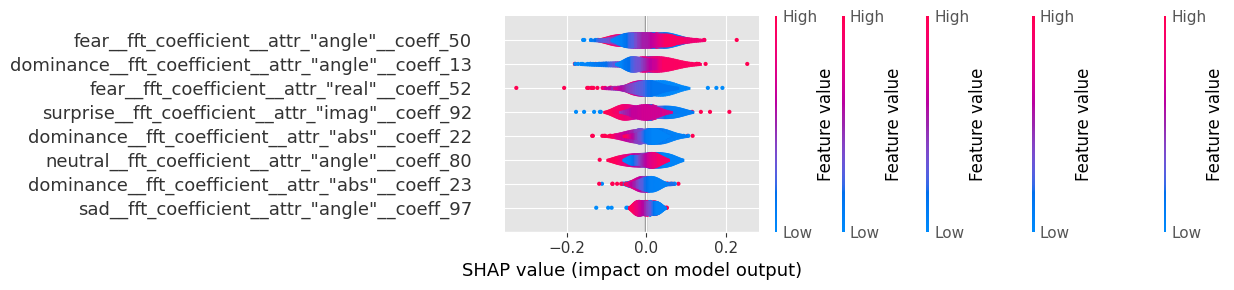

In [45]:
feature_rankings_perma = {}
for dim, models in perma_models.items():
    print(dim)
    X_test = feature_sets[dim]["train"]
    X_test.columns = [col.lower() for col in X_test.columns]
    feature_rankings_perma[dim] = generate_shap_values_and_ranks(dim, models, X_test)

aggregated_ranks = aggregate_ranks(feature_rankings_perma)

In [46]:
def calculate_importance(feature_rankings_perma):
    # Initialize total ranks and counts dictionaries
    total_ranks = {}
    counts = {}

    # Iterate over all dimensions
    for dim, feature_rankings in feature_rankings_perma.items():
        # Iterate over all features in this dimension
        for rank, feature in enumerate(feature_rankings, 1):
            # Update total ranks and counts
            if feature in total_ranks:
                val = 1.1 - 0.1*rank
                total_ranks[feature] += val
                counts[feature] += 1
            else:
                val = 1.1 - 0.1*rank
                total_ranks[feature] = val
                counts[feature] = 1


    # Calculate the average rank for each feature
    #avg_ranks = {feature: total_ranks[feature] / counts[feature] for feature in total_ranks}

    return counts, total_ranks

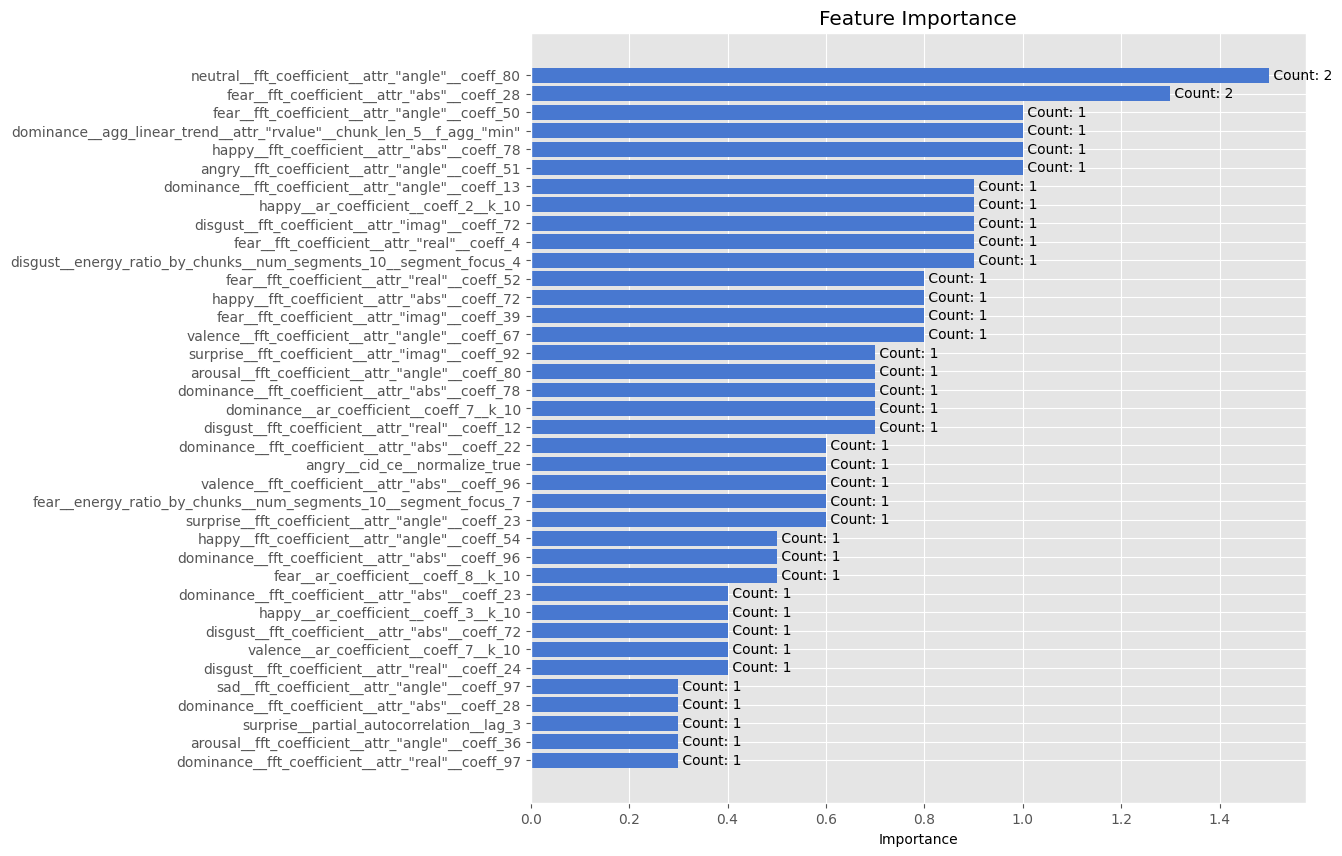

In [47]:
# Apply your function to the data
counts, total_ranks = calculate_importance(aggregated_ranks)

# Sort the dictionary by value
sorted_importance = sorted(total_ranks.items(), key=lambda item: item[1])

# Unpack names and values
names, values = zip(*sorted_importance)

# Create a color palette
palette = sns.color_palette("muted")

fig, ax = plt.subplots(figsize=(10, 10))

# Apply color palette
ax.set_prop_cycle(color=palette)

# Create a horizontal bar plot
ax.barh(names, values)

# Add counts on top of the bars
for i, name in enumerate(names):
    count = counts[name]
    value = values[i]
    ax.text(value, i, f' Count: {count}', va='center')

ax.set_xlabel('Importance')
ax.set_title('Feature Importance')
plt.show()

In [48]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results
    # for model_name, result in results.items():
    #     print(f"{dim} - {model_name}: MAE - {result['mae']}, MSE - {result['mse']}")
    

In [49]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["mae"] < curr_mae:
            curr_mae = results[model]["mae"]
            best_results[dim] = {"model": model, "mae": results[model]["mae"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'BayesianRidge', 'mae': 0.14337398275613822, 'preds': array([0.65519798, 0.64061804, 0.69823986, 0.73421342, 0.56736571,
       0.49231297, 0.64111968, 0.67095943, 0.80126219, 0.60766271,
       0.575502  , 0.77121731, 0.74354808, 0.52369387, 0.7728154 ,
       0.60881749, 0.62199965, 0.71185431, 0.81108186, 0.49114442,
       0.65989661])}, 'E': {'model': 'BayesianRidge', 'mae': 0.24061316330640015, 'preds': array([0.89462896, 0.49136605, 0.56367508, 0.47906207, 0.65870482,
       0.70832079, 0.51947799, 0.49439433, 0.48760025, 0.5514395 ,
       0.66486372, 0.42399626, 0.46865942, 0.44774608, 0.54285209,
       0.62132219, 0.577193  , 0.46899872, 0.40773026, 0.40939151,
       0.48918943])}, 'R': {'model': 'BayesianRidge', 'mae': 0.16811645777435988, 'preds': array([0.83443667, 0.86731563, 0.7714974 , 0.75336051, 0.85710257,
       0.7117101 , 0.78161843, 0.77251841, 0.8432159 , 0.7629134 ,
       0.64287685, 0.63204816, 0.78088554, 0.47465884, 0.8350673 ,
       0.85

In [50]:
best_feats_dict = {}

for dim, results in results_dict.items():
    best_feats_dict[dim] = {model[0]['name']: {"feat_imp": model[0]['best_feats'], "score": model[0]["score"]}  for model in results}

best_feats_dict_dim = {}
    
for dim in ['P', 'E', 'R', 'M', 'A']:
    model = best_results[dim]["model"]
    feat_imp = abs(best_feats_dict[dim][model]["feat_imp"])
    best_feats_dict_dim[dim] = feat_imp

best_feats_dict_dim

{'P': array([0.04140863, 0.0298175 , 0.03302228, 0.02145811, 0.04703993,
        0.02091565, 0.02577609, 0.02051036]),
 'E': array([0.0612226 , 0.01929561, 0.03438397, 0.03389561, 0.0395962 ,
        0.03682694, 0.0273214 , 0.04959555]),
 'R': array([0.02035684, 0.02150413, 0.0157647 , 0.0208891 , 0.02148793,
        0.03105326, 0.01073742, 0.01772576]),
 'M': array([0.05288482, 0.07356409, 0.0315886 , 0.05531461, 0.01692419,
        0.06910309, 0.04475644, 0.07183163]),
 'A': array([0.02612576, 0.04038816, 0.04372355, 0.03819329, 0.03757443,
        0.04339786, 0.02287154, 0.03827369])}

In [51]:
ranked_feats_dict = {}

for (dim, feat_imp_vals), (dim, X_final) in zip(best_feats_dict_dim.items(), feature_sets.items()):
    # Map the feature importance values with the feature list using a dictionary comprehension
    column_names = X_final["train"].columns.tolist()
    feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
    # Rank the features by their importance value in descending order
    ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
    ranked_feats_dict[dim] = ranked_feats

FixedFormatter should only be used together with FixedLocator


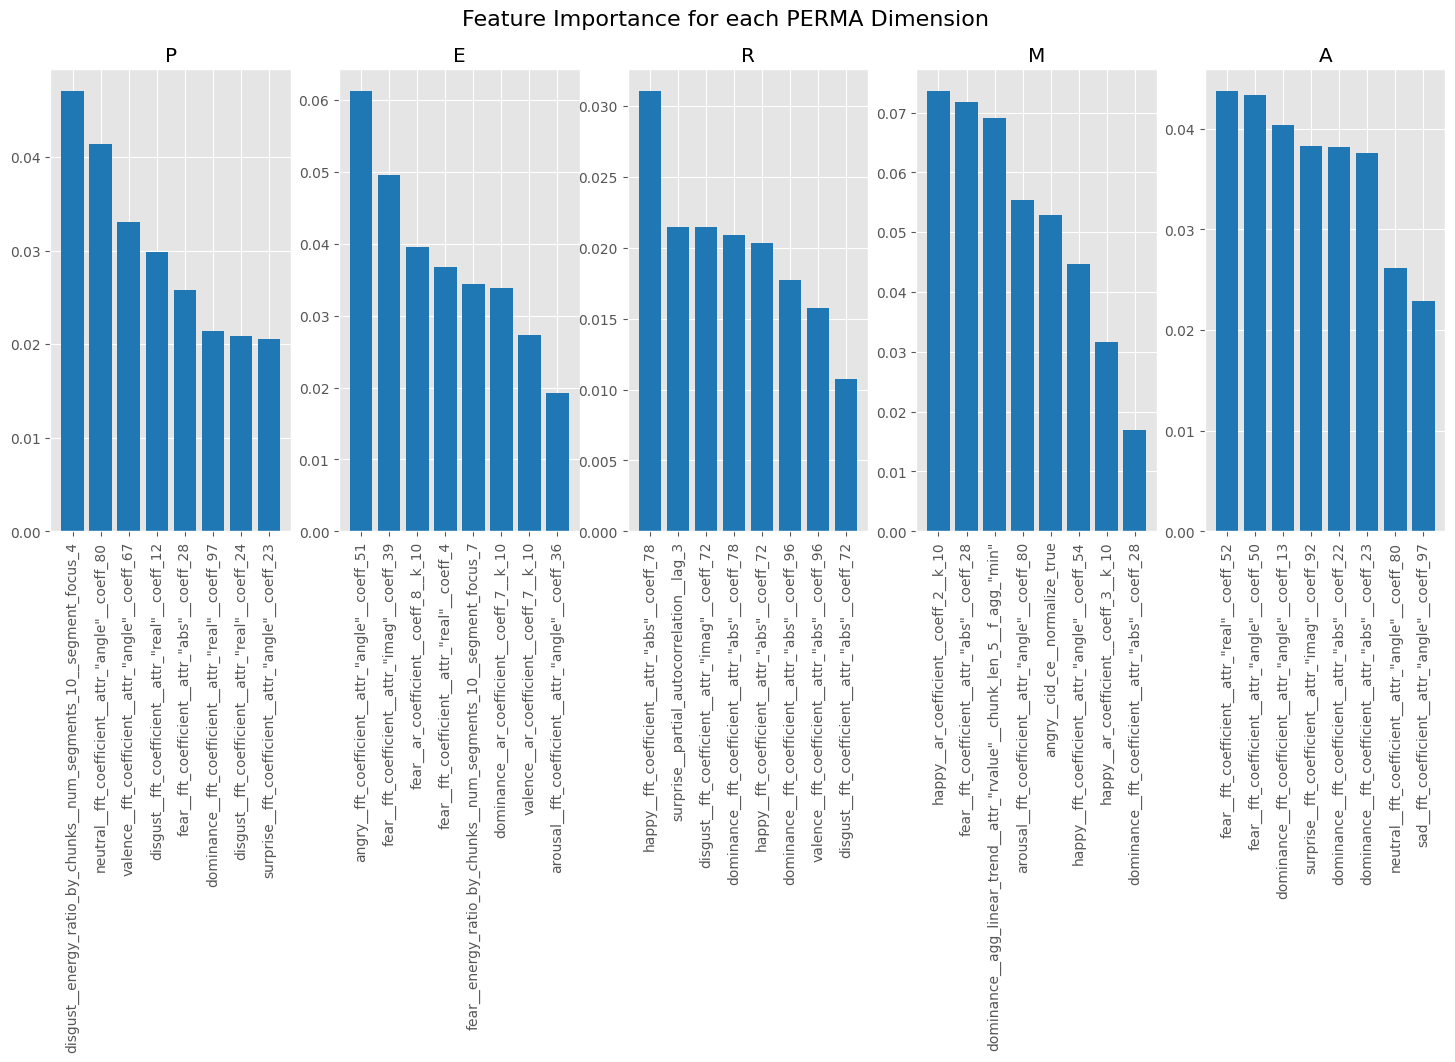

In [52]:
#Separate the feature names and importance scores for each dimension PERMA
P_features, P_scores = zip(*ranked_feats_dict["P"])
E_features, E_scores = zip(*ranked_feats_dict["E"])
R_features, R_scores = zip(*ranked_feats_dict["R"])
M_features, M_scores = zip(*ranked_feats_dict["M"])
A_features, A_scores = zip(*ranked_feats_dict["A"])


#Create a bar plot for each dimension PERMA
fig, axs = plt.subplots(1, 5, figsize=(18, 6))
axs[0].bar(P_features, P_scores)
axs[0].set_title("P")
axs[1].bar(E_features, E_scores)
axs[1].set_title("E")
axs[2].bar(R_features, R_scores)
axs[2].set_title("R")
axs[3].bar(M_features, M_scores)
axs[3].set_title("M")
axs[4].bar(A_features, A_scores)
axs[4].set_title("A")

#Set common axis labels and title
fig.suptitle("Feature Importance for each PERMA Dimension", fontsize=16)
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [53]:
# Baseline:
Y_baseline = np.full_like(Y_test, Y_test.mean(axis=0).transpose())
mae_baseline = mean_absolute_error(Y_test, Y_baseline, multioutput='raw_values')

print(f"Baseline MAE for each dimension: {mae_baseline}")

Baseline MAE for each dimension: [0.16439909 0.20816327 0.14739229 0.20272109 0.1462585 ]


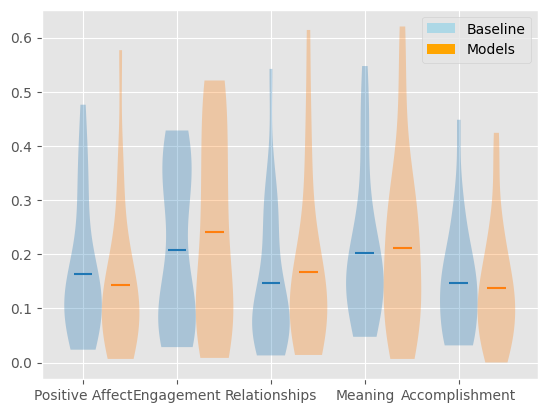

In [54]:
# Calculate the errors between the actual values and the baseline predictions
baseline_errors = abs(Y_test - Y_baseline)

# Calculate the errors for each model and each dimension
model_errors = pd.DataFrame()

# Calculate the errors for each model and each dimension
for dim in ['P', 'E', 'R', 'M', 'A']:
    err = abs(Y_test[dim] - best_results[dim]['preds'])
    errors = pd.DataFrame({'errors': err})
    model_errors = pd.concat([model_errors, errors], axis=1)

# Concatenate baseline and model errors
all_errors = [baseline_errors, model_errors]

# Create a combined boxplot
fig, ax = plt.subplots()
colors = ['lightblue', 'orange']
labels = ['Baseline', 'Models']

for i, error_df in enumerate(all_errors):
    position = np.arange(1, len(error_df.columns) + 1) + (i * 0.4)
    #ax.boxplot(error_df, positions=position, widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.violinplot(error_df, positions=position, widths=0.4, showmedians=False, showextrema=False, showmeans=True)

# Define the labels for the x-axis
perma = ['Positive Affect', 'Engagement', 'Relationships', 'Meaning', 'Accomplishment']

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(1, len(perma) + 1))
ax.set_xticklabels(perma)

# Create the legend patches and labels
patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
ax.legend(handles=patches, loc='upper right')

(0.0, 0.3)

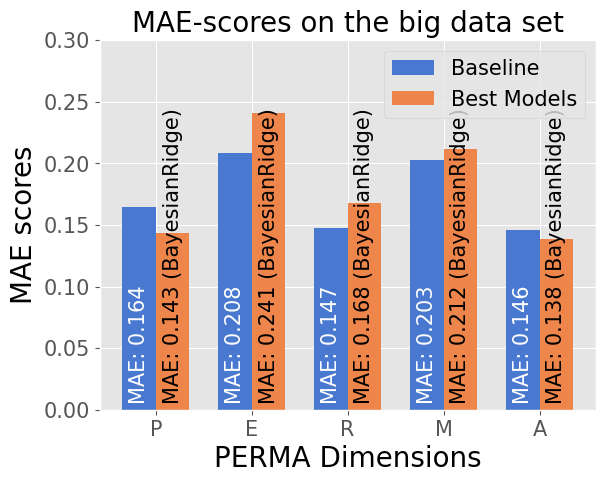

In [55]:
# Print the best model for each PERMA dimension
best_mae_values = [v['mae'] for v in best_results.values()]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
palette = sns.color_palette("muted")
ax.set_prop_cycle(color=palette)
ax.bar(np.arange(len(perma_dimensions)), mae_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_mae_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimensions', fontsize=20)

# Set the y-axis label and limits
ax.set_ylabel('MAE scores', fontsize=20)
ax.set_ylim([0, max(np.max(mae_baseline), np.max(best_mae_values))*1.1])
ax.tick_params(axis='both', which='major', labelsize=15)

# Add the model names and MAE values above each bar
for i, v in enumerate(mae_baseline):
    ax.text(i, 0.005, f"MAE: {v:.3f}", rotation=90, ha='center', va='bottom', fontsize=15, color='white')
    ax.text(i+bar_width, 0.005, f"MAE: {best_mae_values[i]:.3f} ({best_results[perma_dimensions[i]]['model']})", rotation=90, ha='center', va='bottom', fontsize=15, color='black')

# Add a legend and title
ax.legend(fontsize=15)
ax.set_title('MAE-scores on the big data set', fontsize=20)
ax.set_ylim([0, 0.3])

# path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
# image = path + "/mae_big.pdf"
# plt.savefig(image, bbox_inches='tight', dpi=300)

In [56]:
Y_pred = pd.DataFrame()

for dim in ['P', 'E', 'R', 'M', 'A']:
    err = best_results[dim]['preds']
    errors = pd.DataFrame({dim: err})
    Y_pred = pd.concat([Y_pred, errors], axis=1)

# Unscale the data back to the original scale
Y_preds = pd.DataFrame(minmax_scaler.inverse_transform(Y_pred), columns=['P', 'E', 'R', 'M', 'A'])
Y_tests = pd.DataFrame(minmax_scaler.inverse_transform(Y_test), columns=['P', 'E', 'R', 'M', 'A'])
Y_baselines = pd.DataFrame(minmax_scaler.inverse_transform(Y_baseline), columns=['P', 'E', 'R', 'M', 'A'])

In [57]:
Y_baseline_df = pd.DataFrame(Y_baseline, columns=['P', 'E', 'R', 'M', 'A'])

print(Y_pred.min())
print(Y_pred.max())
print(Y_test.min())
print(Y_test.max())

P    0.491144
E    0.407730
R    0.474659
M    0.416227
A    0.539936
dtype: float64
P    0.811082
E    0.894629
R    0.986929
M    0.811170
A    0.915146
dtype: float64
P    0.166667
E    0.200000
R    0.166667
M    0.000000
A    0.250000
dtype: float64
P    1.0
E    1.0
R    1.0
M    1.0
A    1.0
dtype: float64


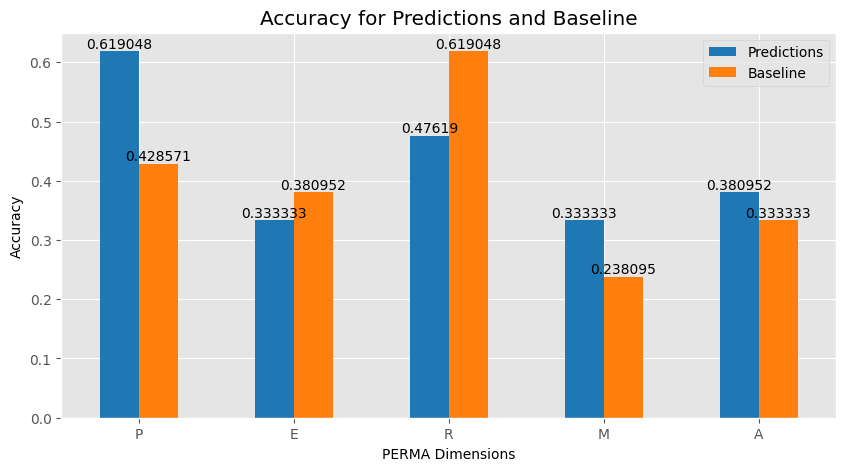

In [58]:
# Define the bins and labels
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

# bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']


# Apply the binning
actual_values_bins = Y_test.apply(pd.cut, bins=bins, labels=labels)
predictions_bins = Y_pred.apply(pd.cut, bins=bins, labels=labels)
baseline_bins = Y_baseline_df.apply(pd.cut, bins=bins, labels=labels)

# Reset the indices of both DataFrames
actual_values_bins.reset_index(drop=True, inplace=True)
predictions_bins.reset_index(drop=True, inplace=True)
baseline_bins.reset_index(drop=True, inplace=True)

# Calculate the accuracy for each column
accur_preds = (actual_values_bins == predictions_bins).mean()
accur_baseline = (actual_values_bins == baseline_bins).mean()

# Combine accuracy values into a single DataFrame
accuracy_df = pd.DataFrame({'Predictions': accur_preds, 'Baseline': accur_baseline})

# Plot the accuracy values for predictions and baseline
ax = accuracy_df.plot(kind='bar', figsize=(10, 5))
plt.title('Accuracy for Predictions and Baseline')
plt.xlabel('PERMA Dimensions')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend()

# Annotate values on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)



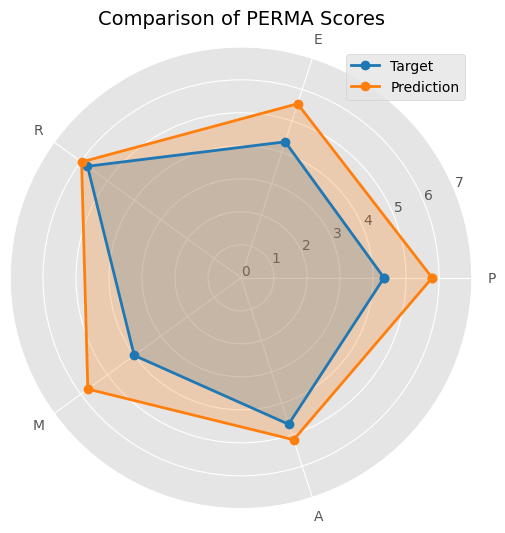

In [59]:
# Define the labels for the radar plots
labels = ['P', 'E', 'R', 'M', 'A']

# Create the figure and subplot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Loop over each row of Y_tests and Y_preds
for i in [np.random.randint(0, len(Y_tests))]:
    # Define the data for the radar plot
    data1 = Y_tests.iloc[i].values
    data2 = Y_preds.iloc[i].values
    #data3 = Y_baselines.iloc[i].values

    # Define the angle for each label
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    # Close the plot
    data1 = np.concatenate((data1, [data1[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    data2 = np.concatenate((data2, [data2[0]]))
    #data3 = np.concatenate((data3, [data3[0]]))

    # Plot the radar plot
    ax.plot(angles, data1, 'o-', linewidth=2, label=f'Target')
    ax.fill(angles, data1, alpha=0.25)
    ax.plot(angles, data2, 'o-', linewidth=2, label=f'Prediction')
    ax.fill(angles, data2, alpha=0.25)
    #ax.plot(angles, data3, 'o-', linewidth=2, label=f'Baseline')
    #ax.fill(angles, data3, alpha=0.25)

# Set the labels
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
plt.yticks(np.arange(0, 7.1, 1.0))
plt.ylim(0, 7)
plt.title('Comparison of PERMA Scores', fontsize=14)
plt.legend()